# Covid 19 - Predictions for Active cases

### Loading libraries

In [1]:
import pandas as pd
import pandas as pd 
import random

In [2]:
import math
import time
import datetime
import operator 
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

In [3]:
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [4]:
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
plt.style.use('seaborn-dark')
#print(plt.style.available)
%matplotlib inline

from sklearn import metrics

In [5]:
from sklearn.ensemble import RandomForestRegressor 
from sklearn.model_selection import GridSearchCV

In [6]:
import warnings
warnings.filterwarnings("ignore")

### Preparation for predictions

#### Data Loading

In [7]:
#dataset
covid_df= pd.read_csv("corona_pred_china.csv")
covid_df.head()

,ObservationDate,Country,Continent,Confirmed,Deaths,Recovered,Active Cases,Population,Area (sq. mi.),Pop. Density (per sq. mi.),Net migration,GDP ($ per capita)
0,2020-01-22,Hong Kong,Asia,0.0,0.0,0.0,0.0,6940432.0,1092.0,"6355,7","5,24",28800.0
1,2020-01-22,Japan,Asia,2.0,0.0,0.0,2.0,127463611.0,377835.0,"337,4",0,28200.0
2,2020-01-22,Macao,Asia,1.0,0.0,0.0,1.0,453125.0,28.0,"16183,0","4,86",19400.0
3,2020-01-22,South Korea,Asia,1.0,0.0,0.0,1.0,48846823.0,98480.0,"496,0",0,17800.0
4,2020-01-22,Taiwan,Asia,1.0,0.0,0.0,1.0,23036087.0,35980.0,"640,3",0,23400.0


#### Data transformations

In [8]:
#Converting "Observation Date" into Datetime format
covid_df["ObservationDate"]=pd.to_datetime(covid_df["ObservationDate"])
covid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3811 entries, 0 to 3810
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   ObservationDate             3811 non-null   datetime64[ns]
 1   Country                     3811 non-null   object        
 2   Continent                   3811 non-null   object        
 3   Confirmed                   3811 non-null   float64       
 4   Deaths                      3811 non-null   float64       
 5   Recovered                   3811 non-null   float64       
 6   Active Cases                3811 non-null   float64       
 7   Population                  3811 non-null   float64       
 8   Area (sq. mi.)              3811 non-null   float64       
 9   Pop. Density (per sq. mi.)  3811 non-null   object        
 10  Net migration               3811 non-null   object        
 11  GDP ($ per capita)          3811 non-null   float64     

In [9]:
# Changing datatype of Population density and Net Migration columns as float
cols=["Pop. Density (per sq. mi.)","Net migration"]                             
for i in cols:
    covid_df[i]=covid_df[i].str.replace(",","").astype(float)
covid_df.info()    

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3811 entries, 0 to 3810
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   ObservationDate             3811 non-null   datetime64[ns]
 1   Country                     3811 non-null   object        
 2   Continent                   3811 non-null   object        
 3   Confirmed                   3811 non-null   float64       
 4   Deaths                      3811 non-null   float64       
 5   Recovered                   3811 non-null   float64       
 6   Active Cases                3811 non-null   float64       
 7   Population                  3811 non-null   float64       
 8   Area (sq. mi.)              3811 non-null   float64       
 9   Pop. Density (per sq. mi.)  3811 non-null   float64       
 10  Net migration               3811 non-null   float64       
 11  GDP ($ per capita)          3811 non-null   float64     

In [10]:
covid_df.head()

,ObservationDate,Country,Continent,Confirmed,Deaths,Recovered,Active Cases,Population,Area (sq. mi.),Pop. Density (per sq. mi.),Net migration,GDP ($ per capita)
0,2020-01-22,Hong Kong,Asia,0.0,0.0,0.0,0.0,6940432.0,1092.0,63557.0,524.0,28800.0
1,2020-01-22,Japan,Asia,2.0,0.0,0.0,2.0,127463611.0,377835.0,3374.0,0.0,28200.0
2,2020-01-22,Macao,Asia,1.0,0.0,0.0,1.0,453125.0,28.0,161830.0,486.0,19400.0
3,2020-01-22,South Korea,Asia,1.0,0.0,0.0,1.0,48846823.0,98480.0,4960.0,0.0,17800.0
4,2020-01-22,Taiwan,Asia,1.0,0.0,0.0,1.0,23036087.0,35980.0,6403.0,0.0,23400.0


In [11]:
# Sorting based on the country names
covid_df = covid_df.sort_values(["Country", "ObservationDate"]).reset_index(drop=True)

In [12]:
covid_df.shape

(3811, 12)

In [13]:
# Calculating days since the first occurance for each country
covid_df['days_since_first']=0
covid_df['previous_Active'] = 0
covid_df['activecase_increase_rate'] = 0
previous_Active=0
confirm_difference=0

for i in covid_df.index[1:]:
    if covid_df['Country'][i]==covid_df['Country'][i-1]:
        covid_df.loc[i,'days_since_first']=(covid_df.at[i-1,'days_since_first']+1)
        previous_Active=covid_df.at[i-1,'Active Cases']
        confirm_difference= covid_df.at[i,'Active Cases']-previous_Active
        covid_df.loc[i,'previous_Active']=previous_Active        
        if ((previous_Active!=0) & (confirm_difference>0) ):
            covid_df.loc[i,'activecase_increase_rate']=((confirm_difference/previous_Active))       
        else:
            covid_df.loc[i,'activecase_increase_rate']=0
    else:
        covid_df.loc[i,'days_since_first'] = 0
        covid_df.loc[i,'previous_Active'] = 0
        covid_df.loc[i,'activecase_increase_rate'] = 0  

In [14]:
# Ensuring that previous Active Cases column type is int
covid_df['previous_Active'].astype(int)
covid_df=covid_df[covid_df['activecase_increase_rate']>=0]

In [15]:
covid_df.set_index('Country',inplace=True)

#### Check for highest number of Active Cases cases in Europe

In [16]:
covid_df_Europe = covid_df[covid_df['Continent'] == "Europe"].groupby('Country').agg(
                {
                     'Active Cases':sum,    # Sum duration per group
                     'days_since_first': max,  # get the max of days
                }).sort_values(["Active Cases", "days_since_first"]).tail()
covid_df_Europe.sort_values(["Active Cases"], ascending=False)

,Active Cases,days_since_first
Country,,
Italy,360932.0,51
Spain,138294.0,50
Germany,134143.0,54
France,96474.0,58
Switzerland,38533.0,26


In [17]:
covid_df.columns

Index(['ObservationDate', 'Continent', 'Confirmed', 'Deaths', 'Recovered',
       'Active Cases', 'Population', 'Area (sq. mi.)',
       'Pop. Density (per sq. mi.)', 'Net migration', 'GDP ($ per capita)',
       'days_since_first', 'previous_Active', 'activecase_increase_rate'],
      dtype='object')

### XGBoost Regressor

In [18]:
X=covid_df.copy()
del X['Continent']
del X['ObservationDate']
del X['Confirmed']
del X['Deaths']
del X['Recovered']
del X['GDP ($ per capita)']
#del X['previous_Activecases']
#del X['previous_Active']
#del X['previous_Active']



In [19]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3811 entries, Afghanistan to Zimbabwe
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Active Cases                3811 non-null   float64
 1   Population                  3811 non-null   float64
 2   Area (sq. mi.)              3811 non-null   float64
 3   Pop. Density (per sq. mi.)  3811 non-null   float64
 4   Net migration               3811 non-null   float64
 5   days_since_first            3811 non-null   int64  
 6   previous_Active             3811 non-null   float64
 7   activecase_increase_rate    3811 non-null   float64
dtypes: float64(7), int64(1)
memory usage: 268.0+ KB


In [20]:
X["Net migration"].fillna(0, inplace=True)
X["Pop. Density (per sq. mi.)"].fillna(0, inplace=True)

In [21]:
X.isnull().any()

Active Cases                  False
Population                    False
Area (sq. mi.)                False
Pop. Density (per sq. mi.)    False
Net migration                 False
days_since_first              False
previous_Active               False
activecase_increase_rate      False
dtype: bool

In [22]:
corr = X.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,Active Cases,Population,Area (sq. mi.),Pop. Density (per sq. mi.),Net migration,days_since_first,previous_Active,activecase_increase_rate
Active Cases,1.00,0.03,0.02,-0.03,0.02,0.29,1.00,-0.02
Population,0.03,1.00,0.30,-0.07,-0.06,0.15,0.03,-0.01
Area (sq. mi.),0.02,0.30,1.00,-0.10,0.08,0.16,0.01,-0.02
Pop. Density (per sq. mi.),-0.03,-0.07,-0.10,1.00,0.29,0.14,-0.03,-0.04
Net migration,0.02,-0.06,0.08,0.29,1.00,0.13,0.01,-0.01
days_since_first,0.29,0.15,0.16,0.14,0.13,1.00,0.29,-0.04
previous_Active,1.00,0.03,0.01,-0.03,0.01,0.29,1.00,-0.02
activecase_increase_rate,-0.02,-0.01,-0.02,-0.04,-0.01,-0.04,-0.02,1.00


In [23]:
# Pick only features that are correlated more than 0.2
y = X['Active Cases']     


In [24]:
print(X.shape)
X.head()

(3811, 8)


,Active Cases,Population,Area (sq. mi.),Pop. Density (per sq. mi.),Net migration,days_since_first,previous_Active,activecase_increase_rate
Country,,,,,,,,
Afghanistan,1.0,31056997.0,647500.0,480.0,2306.0,0,0.0,0.0
Afghanistan,1.0,31056997.0,647500.0,480.0,2306.0,1,1.0,0.0
Afghanistan,1.0,31056997.0,647500.0,480.0,2306.0,2,1.0,0.0
Afghanistan,1.0,31056997.0,647500.0,480.0,2306.0,3,1.0,0.0
Afghanistan,1.0,31056997.0,647500.0,480.0,2306.0,4,1.0,0.0


In [25]:
# To get rid of +e format
pd.options.display.float_format = '{:20,.0f}'.format

#### Train Test Split

In [26]:
X.drop(['Active Cases'], axis=1, inplace=True)


# Break off validation set from training data

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.85, test_size=0.15, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.85, test_size=0.15, random_state=1)

In [27]:
print(f"X_train shape is {X_train.shape}")
print(f"X_test shape is {X_test.shape}")
# print(f"X_validate shape is {X_validate.shape}")
print(f"y_train is {y_train.shape}")
# print(f"y_validate shape is {y_validate.shape}")
print(f"y_test shape is {y_test.shape}")

X_train shape is (2753, 7)
X_test shape is (572, 7)
y_train is (2753,)
y_test shape is (572,)


### XGBoost implementation

#### Defining the model and checking the best score

In [28]:
import xgboost as xgb


In [29]:
xgb_reg = xgb.XGBRegressor(n_estimators=100,  learning_rate=0.08, gamma=0, subsample=0.8,
                           colsample_bytree=1, max_depth=10)

### XGB Regressor

In [30]:
eval_set = [(X_val.to_numpy(), y_val.to_numpy())]

xgb_reg.fit(X_train.to_numpy(),y_train.to_numpy(), early_stopping_rounds=50, eval_metric="rmse", eval_set=eval_set, verbose=True)


[0]	validation_0-rmse:2688.63135
Will train until validation_0-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:2483.11060
[2]	validation_0-rmse:2301.60474
[3]	validation_0-rmse:2161.95703
[4]	validation_0-rmse:2044.69446
[5]	validation_0-rmse:1895.23486
[6]	validation_0-rmse:1752.41199
[7]	validation_0-rmse:1635.98694
[8]	validation_0-rmse:1517.10889
[9]	validation_0-rmse:1430.18774
[10]	validation_0-rmse:1340.21716
[11]	validation_0-rmse:1261.76526
[12]	validation_0-rmse:1190.43176
[13]	validation_0-rmse:1101.70435
[14]	validation_0-rmse:1023.42505
[15]	validation_0-rmse:975.91785
[16]	validation_0-rmse:903.92609
[17]	validation_0-rmse:851.52631
[18]	validation_0-rmse:810.99390
[19]	validation_0-rmse:774.01056
[20]	validation_0-rmse:715.48254
[21]	validation_0-rmse:685.21222
[22]	validation_0-rmse:638.46527
[23]	validation_0-rmse:592.31750
[24]	validation_0-rmse:568.33490
[25]	validation_0-rmse:528.56671
[26]	validation_0-rmse:494.29462
[27]	validation_0-rmse:453.25073
[28]	v

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.08, max_delta_step=0, max_depth=10,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=0.8, tree_method=None,
             validate_parameters=False, verbosity=None)

In [31]:
from sklearn.model_selection import cross_val_score
XGB_accuracies = cross_val_score(estimator = xgb_reg, X = X_train, y = y_train, cv = 10)
print("Mean_XGB_Acc : ", XGB_accuracies.mean())

Mean_XGB_Acc :  0.9849420500611178


#### Feature importance

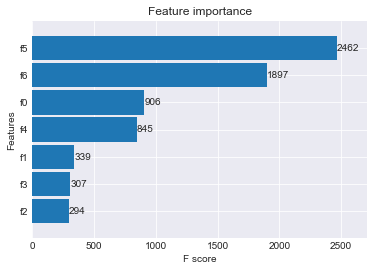

In [32]:
from xgboost import plot_importance, plot_tree
_ = plot_importance(xgb_reg, height=0.9)

In [33]:
X_train.head()

,Population,Area (sq. mi.),Pop. Density (per sq. mi.),Net migration,days_since_first,previous_Active,activecase_increase_rate
Country,,,,,,,
San Marino,"29,251",61,"4,795","1,098",11,35,0
South Korea,"48,846,823","98,480","4,960",0,42,"5,128",0
Switzerland,"7,523,934","41,290","1,822",405,13,332,0
Australia,"20,264,082","7,686,850",26,398,11,10,0
Oman,"3,102,229","212,460",146,28,20,10,0


#### Testing the model

In [34]:
from sklearn.metrics import explained_variance_score
predictions = xgb_reg.predict(X_test.to_numpy())

In [35]:
pred_df = pd.DataFrame({'Actual':y_test.values, 'Pred':predictions}) 
pred_df

,Actual,Pred
0,127,129
1,1,1
2,108,92
3,0,0
4,9,9
...,...,...
567,1,1
568,53,57
569,4,4
570,0,0


#### Evaluation results

In [36]:
print("MAE train: ", metrics.mean_absolute_error(y_train.to_numpy(), xgb_reg.predict(X_train.to_numpy()))) 
print("MSE train: ",metrics.mean_squared_error(y_train.to_numpy(), xgb_reg.predict(X_train.to_numpy())))
print("RMSE train: ",np.sqrt(metrics.mean_squared_error(y_train.to_numpy(), xgb_reg.predict(X_train.to_numpy()))))
print("r2: ",np.sqrt(metrics.r2_score(y_train.to_numpy(), xgb_reg.predict(X_train.to_numpy()))))

print("MAE test: ", metrics.mean_absolute_error(y_test.to_numpy(), xgb_reg.predict(X_test.to_numpy()))) 
print("MSE test: ",metrics.mean_squared_error(y_test.to_numpy(), xgb_reg.predict(X_test.to_numpy())))
print("RMSE test: ",np.sqrt(metrics.mean_squared_error(y_test.to_numpy(), xgb_reg.predict(X_test.to_numpy()))))
print("r2: ",np.sqrt(metrics.r2_score(y_test.to_numpy(), xgb_reg.predict(X_test.to_numpy()))))

MAE train:  2.077627680462315
MSE train:  832.4503579305693
RMSE train:  28.852215823582238
r2:  0.9999240007772197
MAE test:  9.533070692076134
MSE test:  2552.6280510909864
RMSE test:  50.523539574053856
r2:  0.9987745522995766


## XGBoost Regression -  For different countries

### Using Kaggle dataset to cross check the results of future prediction 

In [37]:
covid_df_kaggle= pd.read_csv("covid_19_data_Kaggle.csv")

In [38]:
covid_df_kaggle["ObservationDate"]=pd.to_datetime(covid_df_kaggle["ObservationDate"])

In [39]:
covid_df_kaggle.shape

(13850, 8)

### XGBoost Regression - Italy

In [40]:
covid_df_kaggle_Italy = covid_df_kaggle[covid_df_kaggle["Country/Region"] == "Italy"].groupby("ObservationDate").agg(
                {
                     'Confirmed':sum,    # Sum duration per group
                     'Recovered':sum,    # Sum duration per group
                     'Deaths':sum    # Sum duration per group
                }).sort_values(["ObservationDate"]).reset_index()
covid_df_kaggle_Italy["Active Cases"] = covid_df_kaggle_Italy['Confirmed']-(covid_df_kaggle_Italy['Recovered'] + covid_df_kaggle_Italy['Deaths'])
covid_df_kaggle_Italy

,ObservationDate,Confirmed,Recovered,Deaths,Active Cases
0,2020-01-31,2,0,0,2
1,2020-02-01,2,0,0,2
2,2020-02-02,2,0,0,2
3,2020-02-03,2,0,0,2
4,2020-02-04,2,0,0,2
...,...,...,...,...,...
66,2020-04-06,"132,547","22,837","16,523","93,187"
67,2020-04-07,"135,586","24,392","17,127","94,067"
68,2020-04-08,"139,422","26,491","17,669","95,262"
69,2020-04-09,"143,626","28,470","18,279","96,877"


In [41]:
filter_condn = (covid_df_kaggle_Italy['ObservationDate'] > '2020-03-21') & (covid_df_kaggle_Italy['ObservationDate'] <= '2020-03-26')
covid_df_kaggle_Italy = covid_df_kaggle_Italy[filter_condn].reset_index()
covid_df_kaggle_Italy

X_Italy_df = X[X.index == "Italy"].copy()
X_Italy_test = X_Italy_df.head().copy()
X_Italy_test=X_Italy_test.reset_index(drop=True)
X_Italy_test['days_since_first'] = X_Italy_test['previous_Active'] = X_Italy_test['activecase_increase_rate'] = 0
X_Italy_test.loc[0,'days_since_first'] =  X_Italy_df["days_since_first"].iloc[-1]+1
X_Italy_test.loc[0,'activecase_increase_rate']=X_Italy_df["activecase_increase_rate"].iloc[-1]+1
X_Italy_test.loc[0,'previous_Active'] = y[y.index == "Italy"].max()

for i in range(0,5):
    X_Italy_test.loc[i,'days_since_first'] = X_Italy_test.loc[0,'days_since_first'] + i

X_Italy_test

predictions=[]

for i in range(0,5):
    pred=int(xgb_reg.predict(X_Italy_test.iloc[i]))
    X_Italy_test.loc[i+1,'previous_Active']=pred
    predictions.append(pred)

pred = pd.DataFrame(predictions)

#### Prediction results
X_Italy_test['predicted_infections']=pred.iloc[:, 0] 
X_Italy_test=X_Italy_test[{'predicted_infections'}]
X_Italy_test["Actual infections"] = covid_df_kaggle_Italy["Active Cases"]
X_Italy_test["Date"] = covid_df_kaggle_Italy["ObservationDate"]
X_Italy_test = X_Italy_test.iloc[0:5]
X_Italy_test 

,predicted_infections,Actual infections,Date
0,"45,422","46,638",2020-03-22
1,"44,364","50,418",2020-03-23
2,"44,388","54,030",2020-03-24
3,"44,388","57,521",2020-03-25
4,"44,388","62,013",2020-03-26


### XGBoost Regression - France

In [42]:
covid_df_kaggle_France = covid_df_kaggle[covid_df_kaggle["Country/Region"] == "France"].groupby("ObservationDate").agg(
                {
                     'Confirmed':sum,    # Sum duration per group
                     'Recovered':sum,    # Sum duration per group
                     'Deaths':sum    # Sum duration per group
                }).sort_values(["ObservationDate"]).reset_index()
covid_df_kaggle_France["Active Cases"] = covid_df_kaggle_France['Confirmed']-(covid_df_kaggle_France['Recovered'] + covid_df_kaggle_France['Deaths'])
covid_df_kaggle_France

,ObservationDate,Confirmed,Recovered,Deaths,Active Cases
0,2020-01-24,2,0,0,2
1,2020-01-25,3,0,0,3
2,2020-01-26,3,0,0,3
3,2020-01-27,3,0,0,3
4,2020-01-28,4,0,0,4
...,...,...,...,...,...
73,2020-04-06,"98,963","17,428","8,926","72,609"
74,2020-04-07,"110,065","19,523","10,343","80,199"
75,2020-04-08,"113,959","21,452","10,887","81,620"
76,2020-04-09,"118,781","23,413","12,228","83,140"


In [43]:
filter_condn = (covid_df_kaggle_France['ObservationDate'] > '2020-03-21') & (covid_df_kaggle_France['ObservationDate'] <= '2020-03-26')
covid_df_kaggle_France = covid_df_kaggle_France[filter_condn].reset_index()
covid_df_kaggle_France

X_France_df = X[X.index == "France"].copy()
X_France_test = X_France_df.head().copy()
X_France_test=X_France_test.reset_index(drop=True)
X_France_test['days_since_first'] = X_France_test['previous_Active'] = X_France_test['activecase_increase_rate'] = 0
X_France_test.loc[0,'days_since_first'] =  X_France_df["days_since_first"].iloc[-1]+1
X_France_test.loc[0,'activecase_increase_rate']=X_France_df["activecase_increase_rate"].iloc[-1]+1
X_France_test.loc[0,'previous_Active'] = y[y.index == "France"].max()

for i in range(0,5):
    X_France_test.loc[i,'days_since_first'] = X_France_test.loc[0,'days_since_first'] + i

X_France_test

predictions=[]

for i in range(0,5):
    pred=int(xgb_reg.predict(X_France_test.iloc[i]))
    X_France_test.loc[i+1,'previous_Active']=pred    
    predictions.append(pred)

pred = pd.DataFrame(predictions)

#### Prediction results
X_France_test['predicted_infections']=pred.iloc[:, 0] 
X_France_test=X_France_test[{'predicted_infections'}]
X_France_test["Actual infections"] = covid_df_kaggle_France["Active Cases"]
X_France_test["Date"] = covid_df_kaggle_France["ObservationDate"]
X_France_test = X_France_test.iloc[0:5]
X_France_test 

,predicted_infections,Actual infections,Date
0,"16,553","13,337",2020-03-22
1,"14,962","17,054",2020-03-23
2,"13,571","18,232",2020-03-24
3,"13,047","20,360",2020-03-25
4,"13,058","22,898",2020-03-26


### XGBoost Regression - Spain

In [44]:
covid_df_kaggle_Spain = covid_df_kaggle[covid_df_kaggle["Country/Region"] == "Spain"].groupby("ObservationDate").agg(
                {
                     'Confirmed':sum,    # Sum duration per group
                     'Recovered':sum,    # Sum duration per group
                     'Deaths':sum    # Sum duration per group
                }).sort_values(["ObservationDate"]).reset_index()
covid_df_kaggle_Spain["Active Cases"] = covid_df_kaggle_Spain['Confirmed']-(covid_df_kaggle_Spain['Recovered'] + covid_df_kaggle_Spain['Deaths'])
covid_df_kaggle_Spain

,ObservationDate,Confirmed,Recovered,Deaths,Active Cases
0,2020-02-01,1,0,0,1
1,2020-02-02,1,0,0,1
2,2020-02-03,1,0,0,1
3,2020-02-04,1,0,0,1
4,2020-02-05,1,0,0,1
...,...,...,...,...,...
65,2020-04-06,"136,675","40,437","13,341","82,897"
66,2020-04-07,"141,942","43,208","14,045","84,689"
67,2020-04-08,"148,220","48,021","14,792","85,407"
68,2020-04-09,"153,222","52,165","15,447","85,610"


In [45]:
filter_condn = (covid_df_kaggle_Spain['ObservationDate'] > '2020-03-21') & (covid_df_kaggle_Spain['ObservationDate'] <= '2020-03-26')
covid_df_kaggle_Spain = covid_df_kaggle_Spain[filter_condn].reset_index()
covid_df_kaggle_Spain

X_Spain_df = X[X.index == "Spain"].copy()
X_Spain_test = X_Spain_df.head().copy()
X_Spain_test=X_Spain_test.reset_index(drop=True)
X_Spain_test['days_since_first'] = X_Spain_test['previous_Active'] = X_Spain_test['activecase_increase_rate'] = 0
X_Spain_test.loc[0,'days_since_first'] =  X_Spain_df["days_since_first"].iloc[-1]+1
X_Spain_test.loc[0,'activecase_increase_rate']=X_Spain_df["activecase_increase_rate"].iloc[-1]+1
X_Spain_test.loc[0,'previous_Active'] = y[y.index == "Spain"].max()

for i in range(0,5):
    X_Spain_test.loc[i,'days_since_first'] = X_Spain_test.loc[0,'days_since_first'] + i

X_Spain_test

predictions=[]

for i in range(0,5):
    pred=int(xgb_reg.predict(X_Spain_test.iloc[i]))
    X_Spain_test.loc[i+1,'previous_Active']=pred    
    predictions.append(pred)

pred = pd.DataFrame(predictions)

#### Prediction results
X_Spain_test['predicted_infections']=pred.iloc[:, 0] 
X_Spain_test=X_Spain_test[{'predicted_infections'}]
X_Spain_test["Actual infections"] = covid_df_kaggle_Spain["Active Cases"]
X_Spain_test["Date"] = covid_df_kaggle_Spain["ObservationDate"]
X_Spain_test = X_Spain_test.iloc[0:5]
X_Spain_test 

,predicted_infections,Actual infections,Date
0,"30,669","24,722",2020-03-22
1,"37,406","29,470",2020-03-23
2,"40,885","33,283",2020-03-24
3,"44,216","40,501",2020-03-25
4,"44,216","46,406",2020-03-26


### XGBoost Regression - Germany

In [46]:
covid_df_kaggle_Germany = covid_df_kaggle[covid_df_kaggle["Country/Region"] == "Germany"].groupby("ObservationDate").agg(
                {
                     'Confirmed':sum,    # Sum duration per group
                     'Recovered':sum,    # Sum duration per group
                     'Deaths':sum    # Sum duration per group
                }).sort_values(["ObservationDate"]).reset_index()
covid_df_kaggle_Germany["Active Cases"] = covid_df_kaggle_Germany['Confirmed']-(covid_df_kaggle_Germany['Recovered'] + covid_df_kaggle_Germany['Deaths'])
covid_df_kaggle_Germany

,ObservationDate,Confirmed,Recovered,Deaths,Active Cases
0,2020-01-28,4,0,0,4
1,2020-01-29,4,0,0,4
2,2020-01-30,4,0,0,4
3,2020-01-31,5,0,0,5
4,2020-02-01,8,0,0,8
...,...,...,...,...,...
69,2020-04-06,"103,374","28,700","1,810","72,864"
70,2020-04-07,"107,663","36,081","2,016","69,566"
71,2020-04-08,"113,296","46,300","2,349","64,647"
72,2020-04-09,"118,181","52,407","2,607","63,167"


In [47]:
filter_condn = (covid_df_kaggle_Germany['ObservationDate'] > '2020-03-21') & (covid_df_kaggle_Germany['ObservationDate'] <= '2020-03-26')
covid_df_kaggle_Germany = covid_df_kaggle_Germany[filter_condn].reset_index()
covid_df_kaggle_Germany

X_Germany_df = X[X.index == "Germany"].copy()
X_Germany_test = X_Germany_df.head().copy()
X_Germany_test=X_Germany_test.reset_index(drop=True)
X_Germany_test['days_since_first'] = X_Germany_test['previous_Active'] = X_Germany_test['activecase_increase_rate'] = 0
X_Germany_test.loc[0,'days_since_first'] =  X_Germany_df["days_since_first"].iloc[-1]+1
X_Germany_test.loc[0,'activecase_increase_rate']=X_Germany_df["activecase_increase_rate"].iloc[-1]+1
X_Germany_test.loc[0,'previous_Active'] = y[y.index == "Germany"].max()

for i in range(0,5):
    X_Germany_test.loc[i,'days_since_first'] = X_Germany_test.loc[0,'days_since_first'] + i

X_Germany_test

predictions=[]

for i in range(0,5):
    pred=int(xgb_reg.predict(X_Germany_test.iloc[i]))
    X_Germany_test.loc[i+1,'previous_Active']=pred    
    predictions.append(pred)

pred = pd.DataFrame(predictions)

#### Prediction results
X_Germany_test['predicted_infections']=pred.iloc[:, 0] 
X_Germany_test=X_Germany_test[{'predicted_infections'}]
X_Germany_test["Actual infections"] = covid_df_kaggle_Germany["Active Cases"]
X_Germany_test["Date"] = covid_df_kaggle_Germany["ObservationDate"]
X_Germany_test = X_Germany_test.iloc[0:5]
X_Germany_test 

,predicted_infections,Actual infections,Date
0,"30,429","24,513",2020-03-22
1,"36,633","28,480",2020-03-23
2,"39,987","29,586",2020-03-24
3,"40,785","33,570",2020-03-25
4,"43,505","37,998",2020-03-26


### XGBoost Regression - Switzerland

In [49]:
covid_df_kaggle_Switzerland = covid_df_kaggle[covid_df_kaggle["Country/Region"] == "Switzerland"].groupby("ObservationDate").agg(
                {
                     'Confirmed':sum,    # Sum duration per group
                     'Recovered':sum,    # Sum duration per group
                     'Deaths':sum    # Sum duration per group
                }).sort_values(["ObservationDate"]).reset_index()
covid_df_kaggle_Switzerland["Active Cases"] = covid_df_kaggle_Switzerland['Confirmed']-(covid_df_kaggle_Switzerland['Recovered'] + covid_df_kaggle_Switzerland['Deaths'])
covid_df_kaggle_Switzerland

,ObservationDate,Confirmed,Recovered,Deaths,Active Cases
0,2020-02-25,1,0,0,1
1,2020-02-26,1,0,0,1
2,2020-02-27,8,0,0,8
3,2020-02-28,8,0,0,8
4,2020-02-29,18,0,0,18
5,2020-03-01,27,0,0,27
6,2020-03-02,42,0,0,42
7,2020-03-03,56,2,0,54
8,2020-03-04,90,3,0,87
9,2020-03-05,114,3,1,110


In [50]:
filter_condn = (covid_df_kaggle_Switzerland['ObservationDate'] > '2020-03-21') & (covid_df_kaggle_Switzerland['ObservationDate'] <= '2020-03-26')
covid_df_kaggle_Switzerland = covid_df_kaggle_Switzerland[filter_condn].reset_index()
covid_df_kaggle_Switzerland

X_Switzerland_df = X[X.index == "Switzerland"].copy()
X_Switzerland_test = X_Switzerland_df.head().copy()
X_Switzerland_test=X_Switzerland_test.reset_index(drop=True)
X_Switzerland_test['days_since_first'] = X_Switzerland_test['previous_Active'] = X_Switzerland_test['activecase_increase_rate'] = 0
X_Switzerland_test.loc[0,'days_since_first'] =  X_Switzerland_df["days_since_first"].iloc[-1]+1
X_Switzerland_test.loc[0,'activecase_increase_rate']=X_Switzerland_df["activecase_increase_rate"].iloc[-1]+1
X_Switzerland_test.loc[0,'previous_Active'] = y[y.index == "Switzerland"].max()

for i in range(0,5):
    X_Switzerland_test.loc[i,'days_since_first'] = X_Switzerland_test.loc[0,'days_since_first'] + i

X_Switzerland_test

predictions=[]

for i in range(0,5):
    pred=int(xgb_reg.predict(X_Switzerland_test.iloc[i]))
    X_Switzerland_test.loc[i+1,'previous_Active']=pred    
    predictions.append(pred)

pred = pd.DataFrame(predictions)

#### Prediction results
X_Switzerland_test['predicted_infections']=pred.iloc[:, 0] 
X_Switzerland_test=X_Switzerland_test[{'predicted_infections'}]
X_Switzerland_test["Actual infections"] = covid_df_kaggle_Switzerland["Active Cases"]
X_Switzerland_test["Date"] = covid_df_kaggle_Switzerland["ObservationDate"]
X_Switzerland_test = X_Switzerland_test.iloc[0:5]
X_Switzerland_test 

,predicted_infections,Actual infections,Date
0,"9,222","7,245",2020-03-22
1,"8,097","8,544",2020-03-23
2,"6,775","9,624",2020-03-24
3,"6,709","10,613",2020-03-25
4,"6,707","11,489",2020-03-26
